# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=60,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_16-36-41/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5150 | MulticlassF1Score=0.1874
Batch-30 : CrossEntropyLoss=2.4618 | MulticlassF1Score=0.2203
Batch-45 : CrossEntropyLoss=2.4302 | MulticlassF1Score=0.2794
Batch-60 : CrossEntropyLoss=2.4276 | MulticlassF1Score=0.3259
Batch-75 : CrossEntropyLoss=2.4008 | MulticlassF1Score=0.3559
Batch-90 : CrossEntropyLoss=2.4057 | MulticlassF1Score=0.3817
Batch-105: CrossEntropyLoss=2.3725 | MulticlassF1Score=0.4078
Batch-120: CrossEntropyLoss=2.3833 | MulticlassF1Score=0.4305
Batch-135: CrossEntropyLoss=2.3607 | MulticlassF1Score=0.4489
Batch-150: CrossEntropyLoss=2.3687 | MulticlassF1Score=0.4638
Batch-165: CrossEntropyLoss=2.3560 | MulticlassF1Score=0.4821
Batch-180: CrossEntropyLoss=2.3614 | MulticlassF1Score=0.4976
Batch-195: CrossEntropyLoss=2.3553 | MulticlassF1Score=0.5112
Batch-210: CrossEntropyLoss=2.3622 | MulticlassF1Score=0.5228
Batch-225: CrossEntropyLoss=2.3570 | MulticlassF1Score=0.5328
Batch-226: CrossEntropyLoss=2.3436 | MulticlassF1Score=0.5334

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3531 | MulticlassF1Score=0.6810
Batch-30 : CrossEntropyLoss=2.3719 | MulticlassF1Score=0.6786
Batch-45 : CrossEntropyLoss=2.3390 | MulticlassF1Score=0.6779
Batch-60 : CrossEntropyLoss=2.3411 | MulticlassF1Score=0.6774
Batch-63 : CrossEntropyLoss=2.3604 | MulticlassF1Score=0.6776

Training   : Mean CrossEntropyLoss = 2.4051 | Mean MulticlassF1Score = 0.3914
Validation : Mean CrossEntropyLoss = 2.3480 | Mean MulticlassF1Score = 0.6762

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3476 | MulticlassF1Score=0.6890
Batch-30 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.7017
Batch-45 : CrossEntropyLoss=2.3294 | MulticlassF1Score=0.7034
Batch-60 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.7087
Batch-75 : CrossEntropyLoss=2.3274 | MulticlassF1Score=0.7108
Batch-90 : CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7127
Batch-105: CrossEntropyLoss=2.3575 | MulticlassF1Score=0.7136
Batch-120: CrossEntropyLoss=2.3420 | MulticlassF1Score=0.7145
Batch-135: CrossEntropyLoss=2.3506 | MulticlassF1Score=0.7144
Batch-150: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7189
Batch-165: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7243
Batch-180: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7298
Batch-195: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7342
Batch-210: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7379
Batch-225: CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7411
Batch-226: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.7413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7855
Batch-30 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7898
Batch-45 : CrossEntropyLoss=2.3223 | MulticlassF1Score=0.7894
Batch-60 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7898
Batch-63 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7897

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3289 | Mean MulticlassF1Score = 0.7153
Validation : Mean CrossEntropyLoss = 2.3132 | Mean MulticlassF1Score = 0.7886

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7896
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.7927
Batch-45 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7922
Batch-60 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7922
Batch-75 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7922
Batch-90 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7927
Batch-105: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7931
Batch-120: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7937
Batch-135: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7955
Batch-150: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7967
Batch-165: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.7973
Batch-180: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.7981
Batch-195: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7977
Batch-210: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7985
Batch-225: CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7989
Batch-226: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7989

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.8022
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8012
Batch-45 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.8039
Batch-60 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8056
Batch-63 : CrossEntropyLoss=2.3274 | MulticlassF1Score=0.8055

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3104 | Mean MulticlassF1Score = 0.7944
Validation : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.8035

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8066
Batch-30 : CrossEntropyLoss=2.3200 | MulticlassF1Score=0.8076
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8060
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8073
Batch-75 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8064
Batch-90 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8061
Batch-105: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8065
Batch-120: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8071
Batch-135: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8073
Batch-150: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8065
Batch-165: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8071
Batch-180: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8068
Batch-195: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8072
Batch-210: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8076
Batch-225: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8078
Batch-226: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8078

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8057
Batch-30 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8050
Batch-45 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8042
Batch-60 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8045
Batch-63 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8049

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3074 | Mean MulticlassF1Score = 0.8067
Validation : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.8042

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.8070
Batch-30 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8068
Batch-45 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8075
Batch-60 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8092
Batch-75 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8096
Batch-90 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8089
Batch-105: CrossEntropyLoss=2.3180 | MulticlassF1Score=0.8091
Batch-120: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8092
Batch-135: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8092
Batch-150: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8095
Batch-165: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8096
Batch-180: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8095
Batch-195: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8096
Batch-210: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8096
Batch-225: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8099
Batch-226: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8098

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8069
Batch-30 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.8053
Batch-45 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.8072
Batch-60 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8082
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8086

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3066 | Mean MulticlassF1Score = 0.8089
Validation : Mean CrossEntropyLoss = 2.3069 | Mean MulticlassF1Score = 0.8082

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8186
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8212
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8237
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8265
Batch-75 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8283
Batch-90 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8290
Batch-105: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8284
Batch-120: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8284
Batch-135: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8283
Batch-150: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8289
Batch-165: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8296
Batch-180: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8302
Batch-195: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8299
Batch-210: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8304
Batch-226: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8251
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8275
Batch-45 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8297
Batch-60 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8294
Batch-63 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8293

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8270
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8268

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8222
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8262
Batch-45 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8300
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8349
Batch-75 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8375
Batch-90 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8399
Batch-105: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8399
Batch-120: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8400
Batch-135: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8399
Batch-150: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8399
Batch-165: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8400
Batch-180: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8403
Batch-195: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8403
Batch-210: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8402
Batch-225: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.8400
Batch-226: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8400

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8363
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8376
Batch-60 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8374
Batch-63 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8357
Validation : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8358

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8349
Batch-30 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8357
Batch-45 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8383
Batch-75 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8386
Batch-90 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8391
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8394
Batch-120: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8404
Batch-135: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8410
Batch-150: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8413
Batch-165: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8415
Batch-180: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8425
Batch-195: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8428
Batch-210: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8423
Batch-225: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8426
Batch-226: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8382
Batch-30 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8375
Batch-45 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8383
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8383
Batch-63 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8380

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8395
Validation : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8364

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8397
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8420
Batch-45 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8425
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8410
Batch-75 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8416
Batch-90 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8424
Batch-105: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8433
Batch-120: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8442
Batch-135: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8437
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8438
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8435
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8434
Batch-195: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8437
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8437
Batch-225: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8442
Batch-226: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8496
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8497
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8507
Batch-60 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8505
Batch-63 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8505

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8426
Validation : Mean CrossEntropyLoss = 2.2945 | Mean MulticlassF1Score = 0.8508

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8603
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8590
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8591
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8600
Batch-75 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8605
Batch-90 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8606
Batch-105: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8605
Batch-120: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8603
Batch-135: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8600
Batch-150: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8600
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8601
Batch-180: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8602
Batch-195: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8604
Batch-210: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8605
Batch-225: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8602
Batch-226: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8603

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8547
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8560
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8548
Batch-60 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8547
Batch-63 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8549

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8599
Validation : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8534

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8618
Batch-30 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8624
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8614
Batch-60 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8620
Batch-75 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8627
Batch-90 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8637
Batch-105: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8637
Batch-120: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8638
Batch-135: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8647
Batch-150: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8664
Batch-165: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8677
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8686
Batch-195: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8701
Batch-210: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8716
Batch-225: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8727
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8728

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8854
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8805
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8812
Batch-63 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8814

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2872 | Mean MulticlassF1Score = 0.8651
Validation : Mean CrossEntropyLoss = 2.2845 | Mean MulticlassF1Score = 0.8836

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8903
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8914
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8899
Batch-75 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8910
Batch-90 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8914
Batch-105: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8910
Batch-120: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8906
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8902
Batch-150: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8902
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8901
Batch-180: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8903
Batch-195: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8906
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8908
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8910
Batch-226: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8910

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8809
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8819
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8827
Batch-63 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8834

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8905
Validation : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8819

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8912
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8927
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8923
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8932
Batch-75 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8925
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8923
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.8925
Batch-120: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8927
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8935
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8932
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8932
Batch-180: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8934
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8936
Batch-210: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8937
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8936
Batch-226: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8937

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8892
Batch-30 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8845
Batch-63 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8840

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8930
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8867

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8974
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8987
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8983
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8977
Batch-75 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8979
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8972
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8972
Batch-120: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8971
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8973
Batch-150: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8969
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8967
Batch-180: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8966
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8969
Batch-210: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8968
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8968
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8967

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8885
Batch-63 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8887

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8971
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8875

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8997
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8998
Batch-75 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9001
Batch-90 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9006
Batch-105: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9006
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9005
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9002
Batch-150: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9004
Batch-165: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9004
Batch-180: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9007
Batch-195: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9010
Batch-210: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9008
Batch-225: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9011
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9011

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8883
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8888
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8896
Batch-63 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8894

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.8998
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8908

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9056
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9038
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9039
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9045
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9038
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9034
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9032
Batch-120: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9030
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9031
Batch-150: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9036
Batch-165: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9038
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9033
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9029
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9027
Batch-225: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9026
Batch-226: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9026

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8923
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8929
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8914
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8904
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8903

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9035
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8928

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9002
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9021
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9035
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9047
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9050
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9061
Batch-120: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9054
Batch-135: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9048
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9046
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9043
Batch-180: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9043
Batch-195: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9040
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9041
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9039
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9039

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8825
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8864
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8889
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.8897

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9034
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8872

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9099
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9067
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9058
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9052
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9047
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9044
Batch-120: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9039
Batch-135: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9042
Batch-150: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9045
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9045
Batch-195: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9046
Batch-210: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9048
Batch-225: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9048
Batch-226: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.9048

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8905
Batch-30 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8895
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8900

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9053
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8911

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9066
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9036
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9049
Batch-75 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9046
Batch-90 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9046
Batch-105: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9050
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9052
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9050
Batch-150: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9052
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9055
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9063
Batch-195: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9060
Batch-210: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9063
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9062
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8939
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8899
Batch-60 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8906
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8909

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9052
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8919

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9076
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9088
Batch-75 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9083
Batch-90 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9080
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9074
Batch-120: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9072
Batch-135: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9069
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9069
Batch-180: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9072
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9070
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9071
Batch-225: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9071
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9071

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8896
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8915
Batch-63 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8912

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9075
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8919

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9042
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9057
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9070
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9088
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9095
Batch-90 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9087
Batch-105: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9085
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9088
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9086
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9084
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9078
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9079
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9080
Batch-210: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9080
Batch-225: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9081
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9082

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8930
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8929
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8922
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8925
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8928

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9081
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8920

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9098
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9111
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9106
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9105
Batch-75 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9116
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9116
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9114
Batch-120: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9118
Batch-135: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9122
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9125
Batch-165: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9124
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9126
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9123
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9124
Batch-225: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9122
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9122

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8956
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8966
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8969
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8960
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8963

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9117
Validation : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8949

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9147
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9139
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9135
Batch-105: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9136
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9136
Batch-135: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9131
Batch-150: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9132
Batch-165: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9134
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9133
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9134
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9134
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9136
Batch-226: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9136

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8959
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8972
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8981
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8966
Batch-63 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8962

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9141
Validation : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8976

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9132
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9139
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9141
Batch-105: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9134
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9131
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9134
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9139
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9145
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9147
Batch-195: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9144
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9144
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9142
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8960
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8977
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8970
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8967
Batch-63 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8967

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9143
Validation : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8962

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9171
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9158
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9159
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9154
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9156
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9156
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9155
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9157
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9154
Batch-165: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9150
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9148
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9145
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9146
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9148
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9148

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8960
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8962
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8965
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8962

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9156
Validation : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8967

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9155
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9157
Batch-75 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9163
Batch-90 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9162
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9154
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9155
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9157
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9158
Batch-165: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9155
Batch-180: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9152
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9151
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9152
Batch-225: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9153
Batch-226: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9153

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8978
Batch-30 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8958
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8963
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8975
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8976

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9157
Validation : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8972

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9177
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9152
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9151
Batch-90 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9157
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9157
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9154
Batch-135: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9156
Batch-150: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9158
Batch-165: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9156
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9154
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9157
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9158
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9159
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9159

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.8980
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9003
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8985
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8978
Batch-63 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8978

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9158
Validation : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8988

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9150
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9151
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9156
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9154
Batch-75 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9152
Batch-90 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9153
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9157
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9157
Batch-135: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9157
Batch-150: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9159
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9158
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9159
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9160
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9163
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9162
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9162

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8965
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.8944
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8963
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8971
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8975

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9154
Validation : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8953

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9171
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9176
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9174
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9172
Batch-90 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9167
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9168
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9168
Batch-135: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9169
Batch-150: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9166
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9170
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9169
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9168
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9176
Batch-225: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9185
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9185

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9180
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9169
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9176

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9399
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9395
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9381
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9383
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9388
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9386
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9187
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9180

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9411
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9230

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9451
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9268

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9293

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9485
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9484
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9488
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9483
Batch-150: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9477
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9476
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9269

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9485
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9496
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9509
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9520
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9530
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9531

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2621 | Mean MulticlassF1Score = 0.9485
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9486

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9534
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9506

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9504

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9494

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9528
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9506

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9705
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9500

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9508

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9485

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9498
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9486

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9714
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9722
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9492

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9729
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9718
Batch-90 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9521
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9512
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9494

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9513
Patience = 1/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9734
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9724
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9723
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9719
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9720
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9493

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9715
Batch-90 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9483

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9729
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9729
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9492

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9748
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9722
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9732
Batch-60 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9730
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9729
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9726
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9725
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9719
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9719

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9531
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9725
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9511

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9725
Best MulticlassF1Score validation : 0.9511
Training duration                 : 1.9320 minutes.
Training date                     : 2022-10-19 11:23:34.231724+08:00


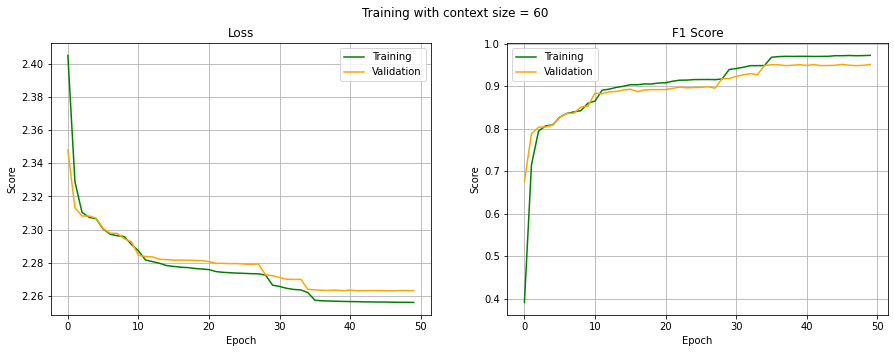

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9725, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9519, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9725, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9519, device='cuda:0'))

## Heatmap

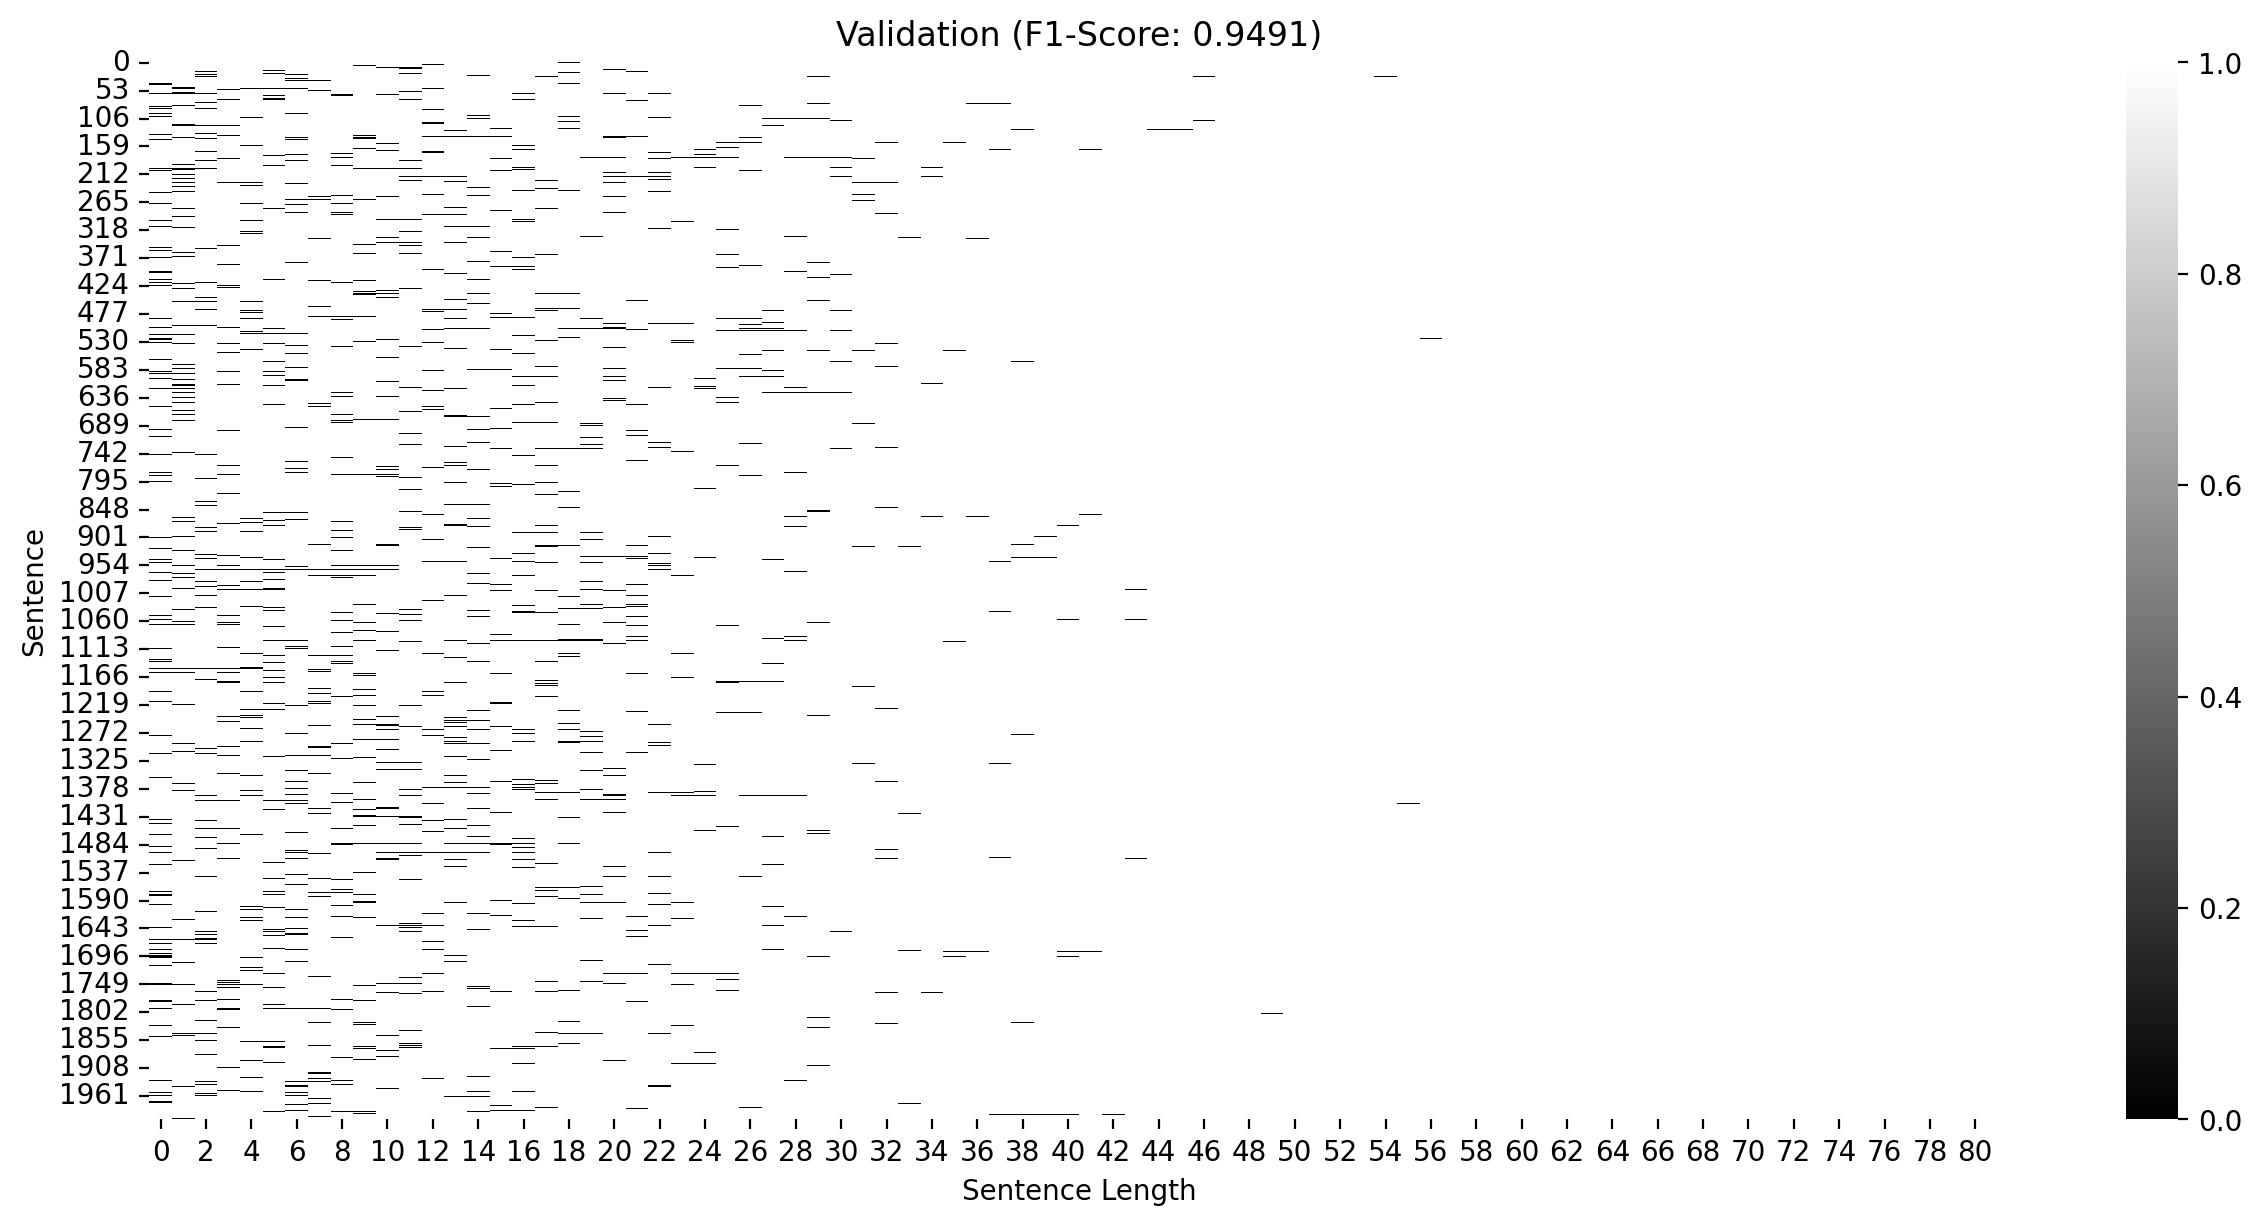

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


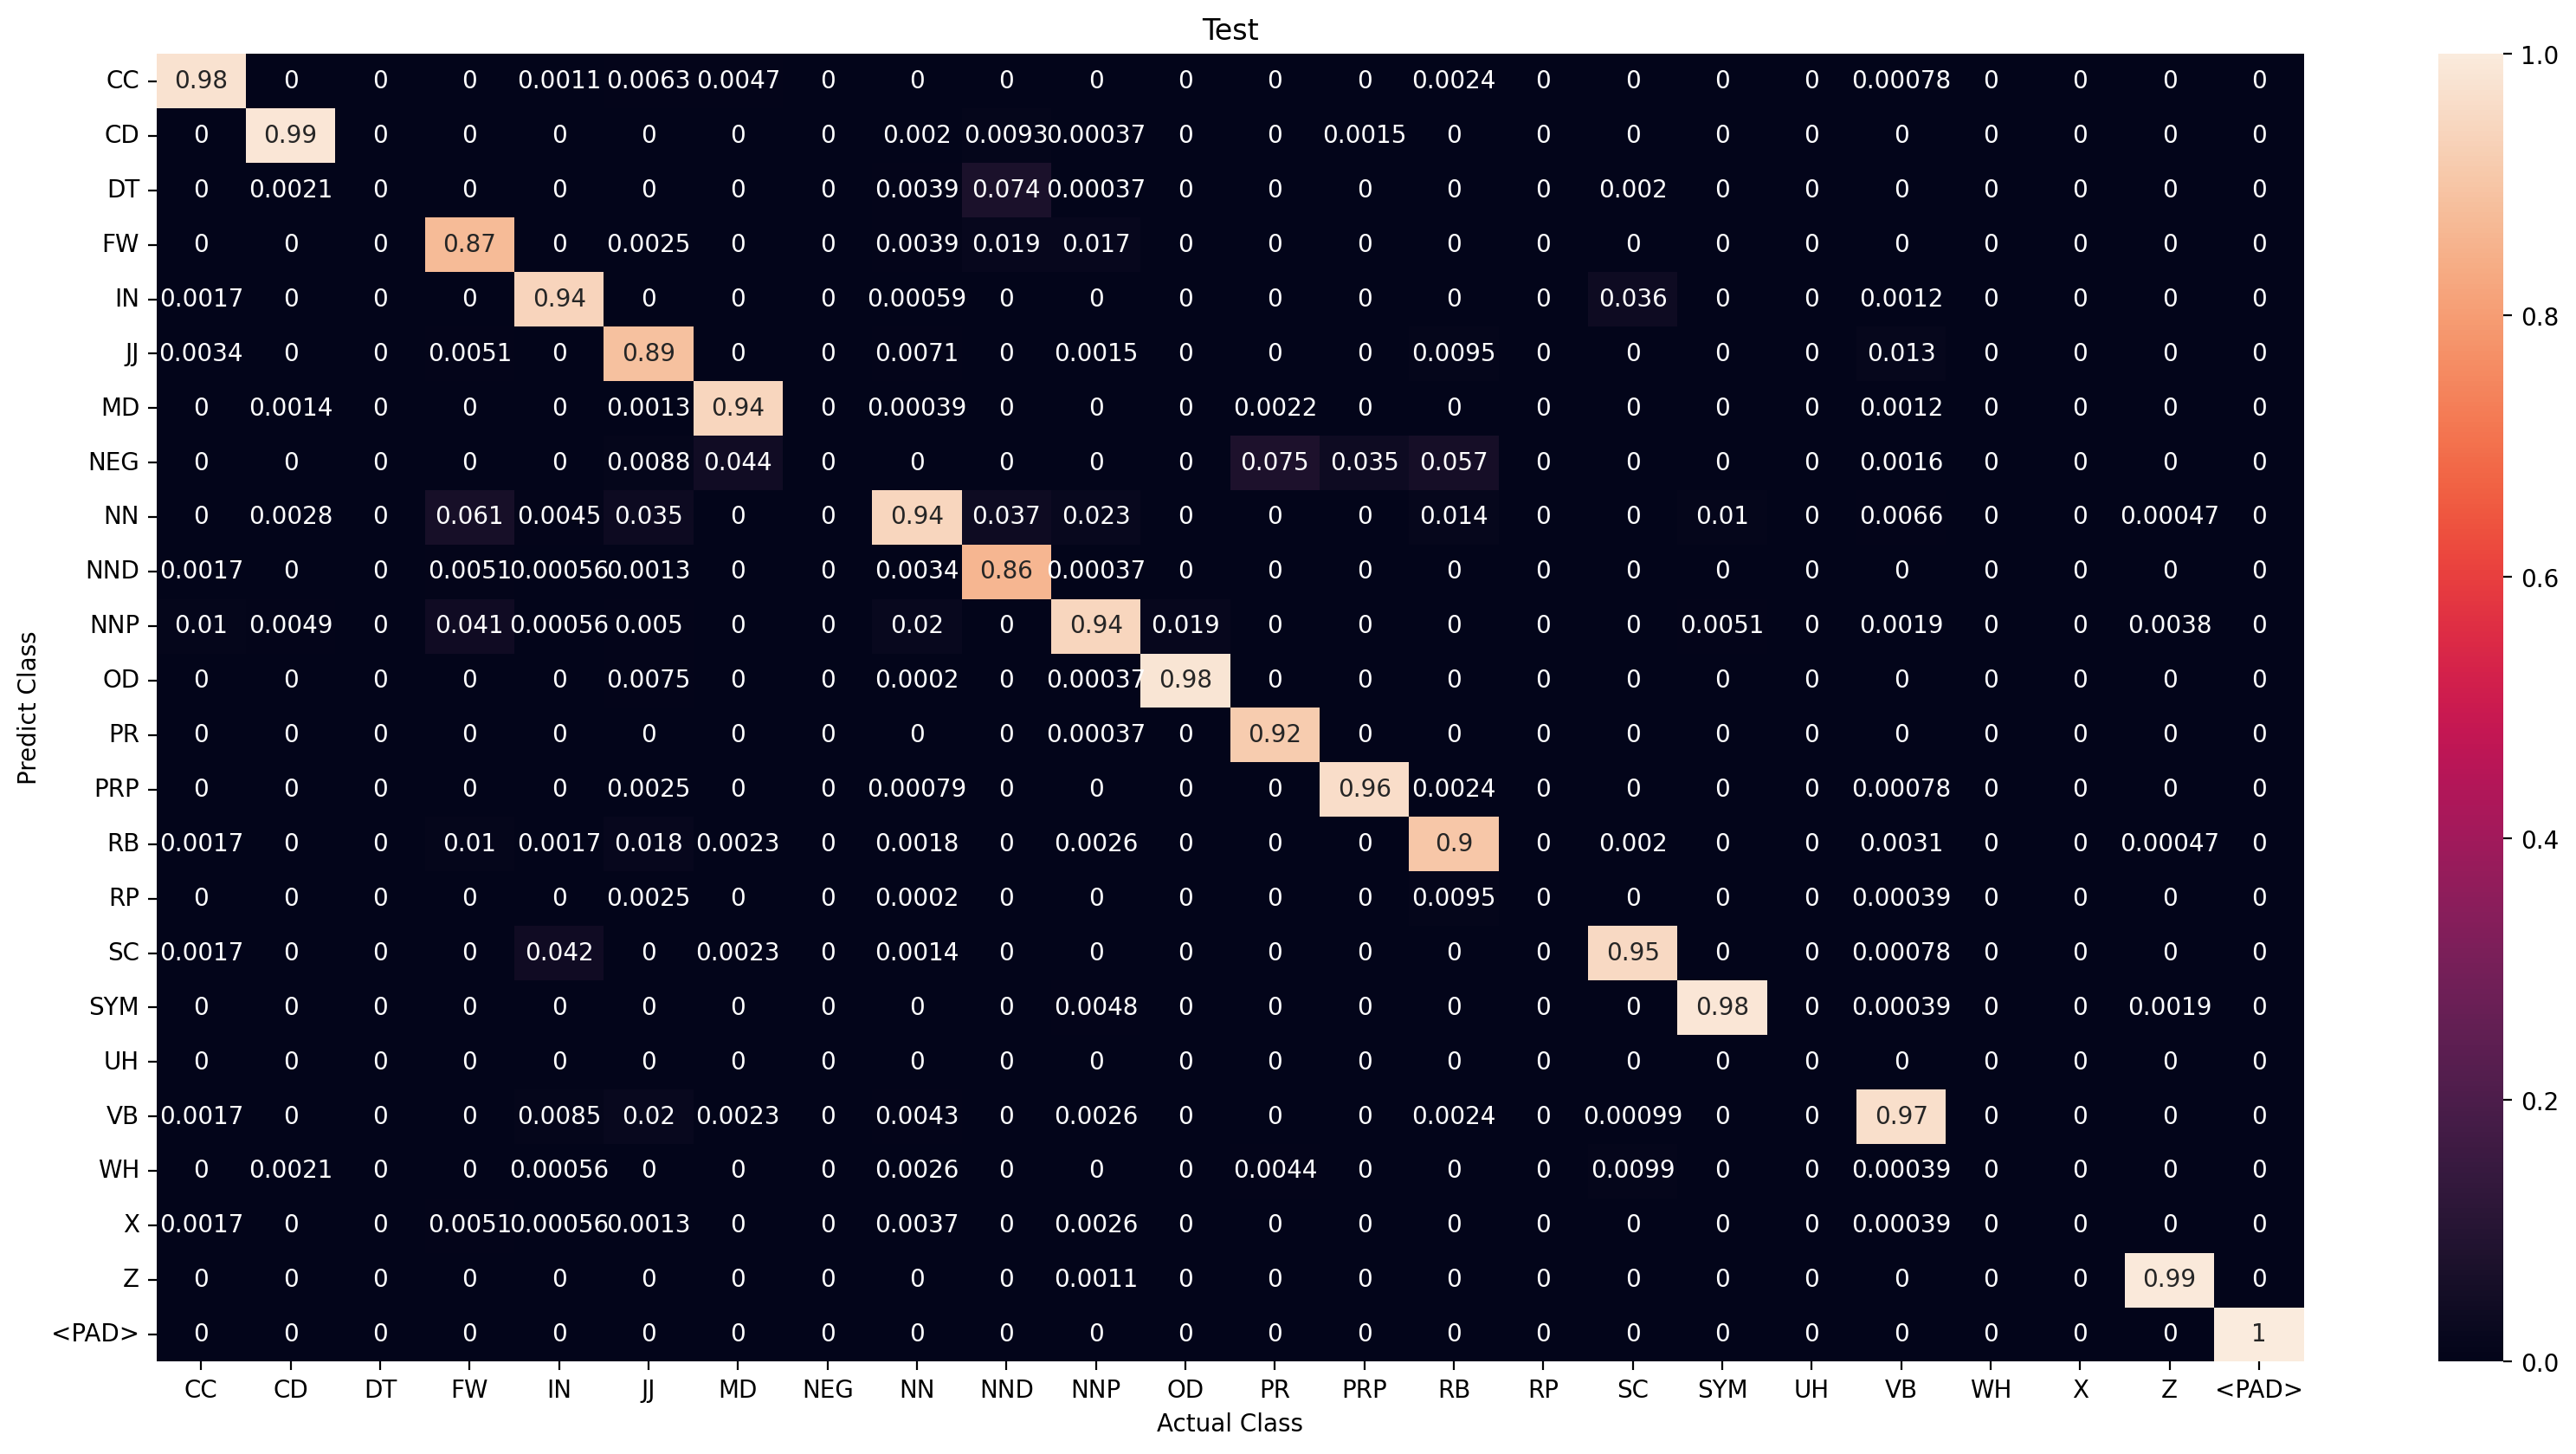

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5216       | CC    : 120      |
| CD    : 12904  | CD    : 12841      | CD    : 63       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1508       | FW    : 189      |
| IN    : 15290  | IN    : 15181      | IN    : 109      |
| JJ    : 7049   | JJ    : 6663       | JJ    : 386      |
| MD    : 3783   | MD    : 3683       | MD    : 100      |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44243      | NN    : 526      |
| NND   : 998    | NND   : 899        | NND   : 99       |
| NNP   : 24884  | NNP   : 24362      | NNP   : 522      |
| OD    : 550    | OD    : 529        | OD    : 21       |
| PR    : 3878   | PR    : 3846       | PR    : 32       |
| PRP   : 5355   | PRP   : 5282       | PRP   : 73       |
| RB    : 3517   | RB    : 3337       | RB    : 180      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11237
Wrong prediction            : 697
Percentage correct oov pred : 94.15954415954417

Validation
Number OOV token            : 3261
Correct prediction          : 2922
Wrong prediction            : 339
Percentage correct oov pred : 89.60441582336706

Test
Number OOV token            : 1367
Correct prediction          : 1229
Wrong prediction            : 138
Percentage correct oov pred : 89.90490124359913



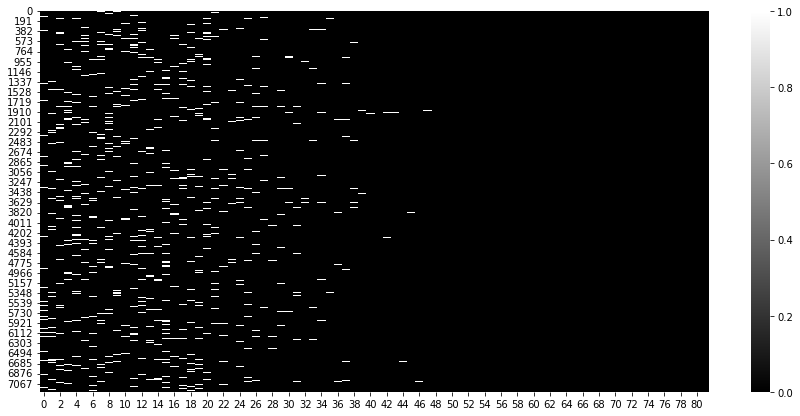

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

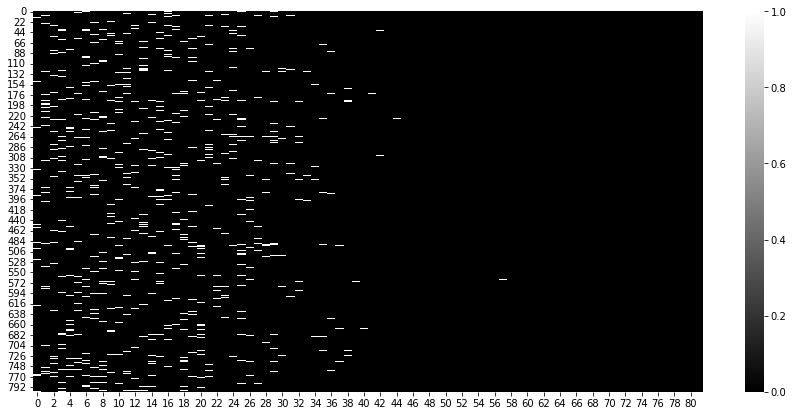

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);